# Modeling: Random Forest and XGBoost

### Importing Libraries

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
import _pickle as pickle

### Loading in the DataFrame

In [116]:
with open("final_df.pickle",'rb') as fp:
    final_df = pickle.load(fp)

### Preparing Data for Modeling

In [117]:
# Assigning appropriate variables for modeling
X = final_df.drop('price_will_increase?', axis=1)
y = final_df['price_will_increase?']

# Splitting the data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#### Scaling the Data
Standardize features by removing the mean and scaling to unit variance.

In [118]:
def scaling(X_train, X_test):
    scaler = StandardScaler()
    scaled_data_train = scaler.fit_transform(X_train)
    scaled_data_test = scaler.transform(X_test)

    #scaled_df_train = pd.DataFrame(scaled_data_train, columns=final_df.columns)
    return scaled_data_train, scaled_data_test

X_train, X_test = scaling(X_train, X_test)

### Function to measure each model's success

In [119]:
def print_metrics(test, preds):
    print("Precision Score: {}".format(precision_score(test, preds)))
    print("Recall Score: {}".format(recall_score(test, preds)))
    print("Accuracy Score: {}".format(accuracy_score(test, preds)))
    print("F1 Score: {}".format(f1_score(test, preds)))

#### Function to plot the confusion matrix

In [204]:
def plot_confusion_matrix(y_true, y_pred, labels=[False, 'Price up > 5%'], 
                          normalize=False, title=None, cmap=plt.cm.cividis):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="crimson" if cm[i, j] > thresh else "crimson",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

### Function to plot important features

In [239]:
def plot_feature_importances(model, X_train):
    X_train = pd.DataFrame(X_train, columns=X.columns)
    n_features = X_train.shape[1]
    plt.figure(figsize=(6,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

## Modeling - Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
# Fitting and training
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Results from the Random Forest Model

In [171]:
# Predictions from RF
y_pred = forest.predict(X_test)

print_metrics(y_test, y_pred)

Precision Score: 0.6188118811881188
Recall Score: 0.6868131868131868
Accuracy Score: 0.6235955056179775
F1 Score: 0.6510416666666667


In [172]:
# Testing Area under the Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC:", round(roc_auc, 4))

AUC: 0.6221


#### Important features according to Random Forest

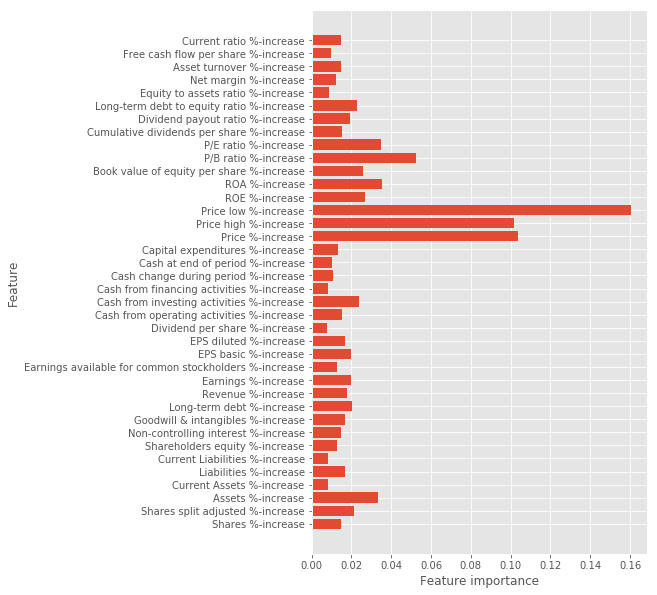

In [240]:
plot_feature_importances(forest, X_train)
plt.savefig('RFfeat.png')

In [173]:
print("Confusion Matrix \n-----------------")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Confusion Matrix 
-----------------


Predicted,False,True,All
Actual,,,
False,97,77,174
True,57,125,182
All,154,202,356


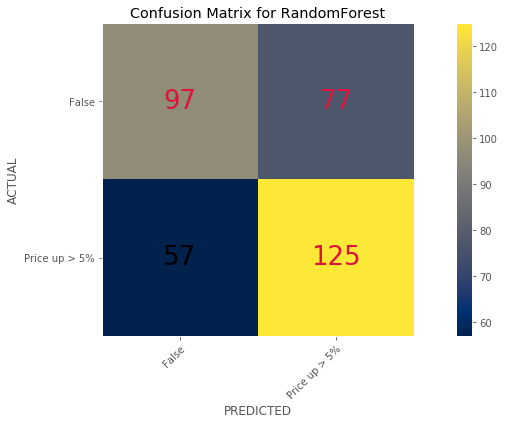

In [174]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for RandomForest")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

### Random Forest - Accuracy: 61.51% and F1 Score: 64.59%.

In [175]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.63      0.56      0.59       174
        True       0.62      0.69      0.65       182

   micro avg       0.62      0.62      0.62       356
   macro avg       0.62      0.62      0.62       356
weighted avg       0.62      0.62      0.62       356



### Improving RandomForest with GridSearchCV

In [126]:
# Using Cross Validation
rf_clf = RandomForestClassifier(n_estimators=100)
rf_cv_score = cross_val_score(rf_clf, X, y, cv=3)
mean_rf_cv_score = np.mean(rf_cv_score)

print("Mean Cross Validation Score:", mean_rf_cv_score*100)

Mean Cross Validation Score: 61.685738769072096


In [127]:
# Setting the Parameters to be tested
rf_param_grid = {'n_estimators': [10,30, 60,100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 2, 5, 10],
                 'min_samples_split': [5,10],
                 'min_samples_leaf': [1, 2, 5]}

#### Finding the Best Parameters along with Accuracy

In [128]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, return_train_score=True, verbose=2)
rf_grid_search.fit(X, y)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.3s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.3s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_s

[CV]  criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.2s
[CV] criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.2s
[CV] criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_leaf=5

[CV]  criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators

[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


[CV]  criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV

[CV]  criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60, total=   0.2s
[CV] criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators

[CV]  criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10 
[CV]  criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_

[CV]  criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.3s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   0.2s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.4s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.4s
[CV] criterion=entropy, max_depth=None, min

[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.3s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.3s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.3s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] criterion=entropy, max_de

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=1, min_

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=30 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=60, total=   0.1s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_s

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=2, min

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total=   0.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=60, total=   0.2s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5, min_

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.3s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60, total=   0.3s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.5s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.5s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   0.5s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.6s


[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 30, 60, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 10], 'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [129]:
print(f"Testing Accuracy: {rf_grid_search.best_score_*100}")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 63.98876404494382
Optimal Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


#### Using the RandomForest parameters from GridSearch

In [235]:
# Fitting and training
forest = RandomForestClassifier(n_estimators=30, max_depth=5, criterion='gini', min_samples_leaf=1, min_samples_split=5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Results from Using the parameters in GridSearch for Random Forest

In [236]:
# Predictions from RF
y_pred = forest.predict(X_test)

print_metrics(y_test, y_pred)

Precision Score: 0.5904761904761905
Recall Score: 0.6813186813186813
Accuracy Score: 0.5955056179775281
F1 Score: 0.6326530612244898


In [211]:
# Testing Area under the Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC:", round(roc_auc, 4))

AUC: 0.6265


In [212]:
# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
y_pred = forest.predict(X_test)
print("Confusion Matrix \n-------------------------")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

       False       0.66      0.51      0.57       174
        True       0.61      0.75      0.67       182

   micro avg       0.63      0.63      0.63       356
   macro avg       0.63      0.63      0.62       356
weighted avg       0.63      0.63      0.62       356

Confusion Matrix 
-------------------------


Predicted,False,True,All
Actual,,,
False,88,86,174
True,46,136,182
All,134,222,356


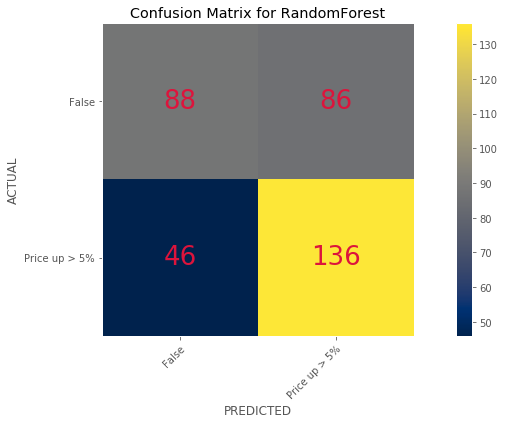

In [213]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for RandomForest")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.savefig('RFConMat.png')
plt.show()

### Random Forest (w/GridSearch) - Accuracy: 62.92% and F1 Score: 67.32%.

## Modeling - XGBoost

In [134]:
# Preventing error from occuring: XGBoost causes kernel to die.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost as xgb

In [182]:
# Fitting and training the model
x_clf = xgb.XGBClassifier()
x_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

### Results from XGBoost

In [183]:
y_pred = x_clf.predict(X_test)

print_metrics(y_test, y_pred)

Precision Score: 0.6019417475728155
Recall Score: 0.6813186813186813
Accuracy Score: 0.6067415730337079
F1 Score: 0.6391752577319587


In [184]:
# Area under the curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC:", round(roc_auc, 4))

AUC: 0.605


#### Important features according to XGBoost

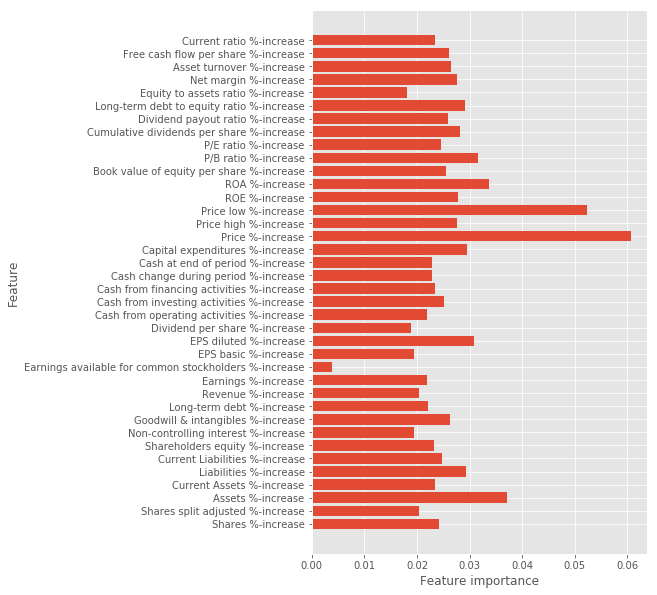

In [241]:
plot_feature_importances(x_clf, X_train)

In [185]:
# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
y_pred = x_clf.predict(X_test)
print("Confusion Matrix \n-------------------------")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

       False       0.61      0.53      0.57       174
        True       0.60      0.68      0.64       182

   micro avg       0.61      0.61      0.61       356
   macro avg       0.61      0.61      0.60       356
weighted avg       0.61      0.61      0.60       356

Confusion Matrix 
-------------------------


Predicted,False,True,All
Actual,,,
False,92,82,174
True,58,124,182
All,150,206,356


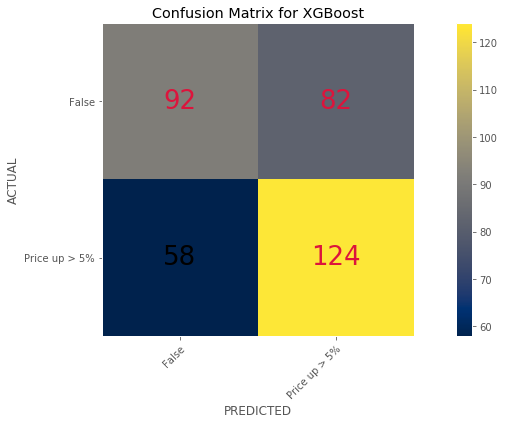

In [186]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for XGBoost")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

### XGBoost - Accuracy: 60.67% and F1 Score: 63.91%.

### Improving XGBoost with GridSearch

In [139]:
# Using Cross Validation for XGB
x_clf = xgb.XGBClassifier()
x_cv_score = cross_val_score(x_clf, X, y, cv=3)
mean_x_cv_score = np.mean(x_cv_score)

print("Mean Cross Validation Score:", mean_x_cv_score*100)

Mean Cross Validation Score: 60.896692146692146


In [140]:
x_param_grid = {'learning_rate': [1, .1],
                'max_depth': [1, 2, 3, 5],
                'booster': ['gbtree', 'gblinear', 'dart'],
                'subsample': [.7, .5, 1],
                'n_estimators': [10,50,100]}

In [141]:
x_grid_search = GridSearchCV(x_clf, x_param_grid, cv=3, return_train_score=True, verbose=2)
x_grid_search.fit(X, y)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.5 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.5, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.5 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=0.5, total=   0.0s
[CV] booster=gbtree, learning_ra

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=1 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=1, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=1 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=1, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=1 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=10, subsample=1, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=50, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=50, subsample=0.7, total=   0.1s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=50, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=1, n_estimators=50, subsample=0.7, total=   0.1s
[CV] booster=gbtree, learning_rate=1, max_depth=1, n_estimators=50, subsample=0.7 
[CV]  booster=gbtree, le

[CV]  booster=gbtree, learning_rate=1, max_depth=2, n_estimators=100, subsample=1, total=   0.3s
[CV] booster=gbtree, learning_rate=1, max_depth=2, n_estimators=100, subsample=1 
[CV]  booster=gbtree, learning_rate=1, max_depth=2, n_estimators=100, subsample=1, total=   0.3s
[CV] booster=gbtree, learning_rate=1, max_depth=2, n_estimators=100, subsample=1 
[CV]  booster=gbtree, learning_rate=1, max_depth=2, n_estimators=100, subsample=1, total=   0.3s
[CV] booster=gbtree, learning_rate=1, max_depth=3, n_estimators=10, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=3, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=3, n_estimators=10, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=3, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gbtree, learning_rate=1, max_depth=3, n_estimators=10, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=3, n_estimators=10, subsample=0.7, total=   0.0s
[C

[CV]  booster=gbtree, learning_rate=1, max_depth=5, n_estimators=50, subsample=1, total=   0.3s
[CV] booster=gbtree, learning_rate=1, max_depth=5, n_estimators=50, subsample=1 
[CV]  booster=gbtree, learning_rate=1, max_depth=5, n_estimators=50, subsample=1, total=   0.3s
[CV] booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.7, total=   0.5s
[CV] booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.7, total=   0.5s
[CV] booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.7 
[CV]  booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.7, total=   0.5s
[CV] booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.5 
[CV]  booster=gbtree, learning_rate=1, max_depth=5, n_estimators=100, subsample=0.5, total=   

[CV]  booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.7, total=   0.2s
[CV] booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.7 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.7, total=   0.2s
[CV] booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.7 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.7, total=   0.2s
[CV] booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5, total=   0.1s
[CV] booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5, total=   0.2s
[CV] booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.5 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=2, n_estimators=50, subs

[CV]  booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7, total=   0.1s
[CV] booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.5 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.5, total=   0.1s
[CV] booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.5 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.5, total=   0.1s
[CV] booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.5 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.5, total=   0.1s
[CV] booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1, total=   0.1s
[CV] booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=1 
[CV]  booster=gbtree, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=

[CV]  booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=0.7, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=0.5 
[CV]  booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=0.5 
[CV]  booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=0.5 
[CV]  booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=1 
[CV]  booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=1, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100, subsample=1 
[CV]  booster=gblinear, learning_rate=1, max_depth=1, n_estimators=100,

[CV]  booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=0.5 
[CV]  booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=0.5 
[CV]  booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=1 
[CV]  booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=1, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=1 
[CV]  booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=1, total=   0.1s
[CV] booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=1 
[CV]  booster=gblinear, learning_rate=1, max_depth=3, n_estimators=50, subsample=1, t

[CV]  booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=10, subsample=1, total=   0.0s
[CV] booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.7, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.7, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.7, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.5 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=1, n_estimators=50, subsample=0.5 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=1, n

[CV]  booster=gblinear, learning_rate=0.1, max_depth=2, n_estimators=100, subsample=1, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7, total=   0.0s
[CV] booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5, total=   0.0s
[CV] booster=gblinear, learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=3, 

[CV]  booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5 
[CV]  booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5, total=   0.1s
[CV] booster=gblinear, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5 
[CV]  booster=gblinear, learning_rate=0.1, max_d

[CV]  booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.7, total=   0.2s
[CV] booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.7 
[CV]  booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.7, total=   0.2s
[CV] booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.7 
[CV]  booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.7, total=   0.2s
[CV] booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.5 
[CV]  booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.5, total=   0.2s
[CV] booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.5 
[CV]  booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.5, total=   0.2s
[CV] booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.5 
[CV]  booster=dart, learning_rate=1, max_depth=2, n_estimators=50, subsample=0.5, total=   0.2s
[CV] booster=dart, 

[CV]  booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=0.7, total=   0.1s
[CV] booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=0.5 
[CV]  booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=0.5, total=   0.1s
[CV] booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=0.5 
[CV]  booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=0.5, total=   0.1s
[CV] booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=0.5 
[CV]  booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=0.5, total=   0.1s
[CV] booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=1 
[CV]  booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=1, total=   0.1s
[CV] booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=1 
[CV]  booster=dart, learning_rate=1, max_depth=5, n_estimators=10, subsample=1, total=   0.1s
[CV] booster=dart, learning

[CV]  booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=0.5, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=0.5 
[CV]  booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=0.5, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=0.5 
[CV]  booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=0.5, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=1 
[CV]  booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=1, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=1 
[CV]  booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=1, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=1 
[CV]  booster=dart, learning_rate=0.1, max_depth=1, n_estimators=100, subsample=1, total=   0.3

[CV]  booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5, total=   0.2s
[CV] booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5 
[CV]  booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5, total=   0.2s
[CV] booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1 
[CV]  booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1 
[CV]  booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1 
[CV]  booster=dart, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1, total=   0.3s
[CV] booster=dart, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7 
[CV]  booster=dart, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7, total=   0.6s
[CV] bo

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [1, 0.1], 'max_depth': [1, 2, 3, 5], 'booster': ['gbtree', 'gblinear', 'dart'], 'subsample': [0.7, 0.5, 1], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [142]:
print(f"Testing Accuracy: {x_grid_search.best_score_*100}")
print(f"Optimal Parameters: {x_grid_search.best_params_}")

Testing Accuracy: 62.752808988764045
Optimal Parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.5}


In [214]:
# Fitting and training XGB
x_clf = x_grid_search.best_estimator_
x_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.5, verbosity=1)

### Results from GridSearch Parameters for XGBoost

In [215]:
y_pred = x_clf.predict(X_test)

print_metrics(y_test, y_pred)

Precision Score: 0.6185567010309279
Recall Score: 0.6593406593406593
Accuracy Score: 0.6179775280898876
F1 Score: 0.6382978723404256


In [216]:
# Area under the curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC:", round(roc_auc, 4))

AUC: 0.617


In [217]:
# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
y_pred = x_clf.predict(X_test)
print("Confusion Matrix \n-------------------------")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

       False       0.62      0.57      0.60       174
        True       0.62      0.66      0.64       182

   micro avg       0.62      0.62      0.62       356
   macro avg       0.62      0.62      0.62       356
weighted avg       0.62      0.62      0.62       356

Confusion Matrix 
-------------------------


Predicted,False,True,All
Actual,,,
False,100,74,174
True,62,120,182
All,162,194,356


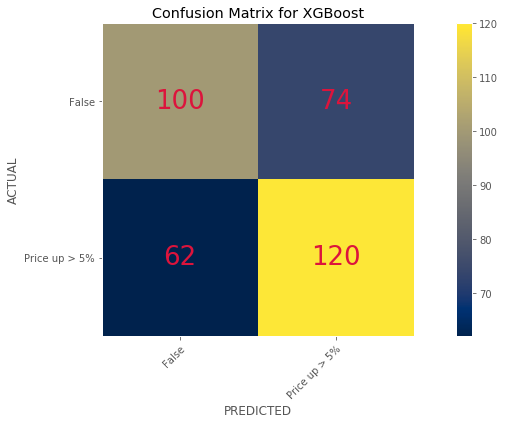

In [218]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for XGBoost")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.savefig('XConMat.png')
plt.show()

### XGBoost(w/GridSearch) - Accuracy: 61.79% and F1 Score: 63.82%.